In [1]:
import sys
sys.path.append("../")
from Dataloader.Dataset import *
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


Dataset path: /afm01/UQ/Q2051


In [2]:
def preprocess_adata(adatas, hvg=False):
    for adata in adatas:
        adata.var_names_make_unique()  
        if hvg:
            sc.pp.filter_genes(adata, min_cells=adata.shape[0]*0.1)
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
    return adatas

In [5]:
def concat_adatas(dataset_name, hvg=False):
    # Skin cancer cSCC dataset
    if dataset_name == "Skin_cSCC":
        # Bugs in the dataset
        # exclude these genes 'NOG', 'FGF1', 'ANGPT1', 'MAPK10', 'SIX1', 'RASGRF1', 'DTX1'
        adatas = []
        target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy", allow_pickle=True)
        for i in range(11):
            gc.collect()
            target_gene_list = ['NOG']
            te_data = CSCC(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", exp_norm="log1p",
                            gene_list=target_gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas, hvg=hvg)
        
    elif dataset_name == "BC_Her2ST":
        # Breast cancer Her2ST dataset
        target_gene_list = np.load("../Dataset/Gene_list/Gene_list_func_BC_Her2ST.npy", allow_pickle=True)
        adatas = []
        for i in range(36):
            gc.collect()
            te_data = Her2st(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", gene_list=target_gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas)
    elif dataset_name == "BC_visium":
        # BC_Visium dataset
        
        # Dataset path
        data_dir1 = "../Dataset/Alex_NatGen_6BreastCancer/"
        data_dir2 = "../Dataset/breast_cancer_10x_visium/"

        # Sample names
        samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
        samps2 = ["block1", "block2", "FFPE"]

        # Store all adata into one dictionary, key is the slide name, value is the anndata objects
        name_slides = samps1+samps2
        print(name_slides)

        # Store sample's path into dictionary
        samples1 = {i:data_dir1 + i for i in samps1}
        samples2 = {i:data_dir2 + i for i in samps2}
            
        # Read preprocessing adata
        adata_dict1 = {name: sc.read_h5ad(f"{data_dir1}processed_adata/{name}.h5ad") for name, path in tqdm.tqdm(samples1.items())}
        adata_dict2 = {name: sc.read_h5ad(f"{data_dir2}processed_adata/{name}.h5ad") for name, path in tqdm.tqdm(samples2.items())}

        adatas = []
        gc.collect()
        for i, m in adata_dict1.items():
            adatas.append(m)
        for i, m in adata_dict2.items():
            adatas.append(m)
        adatas = preprocess_adata(adatas, hvg=hvg)
        
    elif dataset_name == "Liver_visium":
        # Liver disease dataset
        data_path = "../Dataset/liver_Visium/"
        gene_list = list(np.load('../Dataset/Gene_list/Gene_list_func_Liver_visium.npy', allow_pickle=True))
        adatas = []
        for i in range(4):
            gc.collect()
            te_data = Liver_visium(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", gene_list=gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas, hvg=hvg)
        
    elif dataset_name == "Skin_Melanoma":
        # Skin cancer menaloma dataset
        data_path = "../Dataset/Skin_Melanoma/"
        name_slides = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
        adatas = [sc.read_visium(f"{data_path}{name_slide}") for name_slide in name_slides]
        adatas = preprocess_adata(adatas, hvg=hvg)
    
    elif dataset_name == "Kidney_visium":
        # Kidney cancer dataset
        data_path = f"../Dataset/{dataset_name}/Processed_Data"
        name_slides = ["A", "B", "C", "D", "Visium14_C", "Visium14_D"]
        adatas = [sc.read_h5ad(f"{data_path}/{name_slide}.h5ad") for name_slide in name_slides]
        adatas = preprocess_adata(adatas, hvg=hvg)
        
    init = set(adatas[0].var_names)
    for adata in adatas:
        init = init & set(adata.var_names)
    init = list(init)
    adatas = [adata[:, init] for adata in adatas]
    return adatas, init

In [25]:
def save_top5_genes_adata(dataset_name):
    if dataset_name == "Skin_cSCC": # "Skin_cSCC", "BC_Her2ST", "BC_visium", "Liver_visium", "Skin_Melanoma", "Kidney_visium"
        predictable_genes = ["PFN1", "SFN", "CD44", "CTSD", "IFI27"]
    elif dataset_name == "BC_Her2ST":
        predictable_genes = ["CD24", "GNAS", "ERBB2", "HSP90B1", "CD46"]
    elif dataset_name == "BC_visium":
        predictable_genes = ["GNAS", "MARCKSL1", "GTF2I", "PRKDC", "LAMP1"]
    elif dataset_name == "Liver_visium":
        predictable_genes = ["APOE", "C1S", "CLU", "APOB", "SERPING1"]
    elif dataset_name == "Skin_Melanoma":
        predictable_genes = ["HSPB1", "PFN1", "CALML5", "ANXA2", "APOE"]
    elif dataset_name == "Kidney_visium":
        predictable_genes = ["CD74", "HLA-E", "DDIT4", "CTSB", "CTNNA1"]

    adatas, gene_list = concat_adatas(dataset_name, hvg=False)
    predictable_adata = ad.concat(adatas)[:, predictable_genes].copy()
    predictable_adata.write_h5ad(f"../Dataset/Predictable_adata/Top5_{dataset_name}_func.h5ad")
    return predictable_adata

In [ ]:
# Save the adata of top 5 genes for each dataset
dataset_names = ["Skin_cSCC", "BC_Her2ST", "BC_visium", "Liver_visium", "Skin_Melanoma", "Kidney_visium"]

for dataset_name in dataset_names:
    predictable_adata = save_top5_genes_adata(dataset_name)

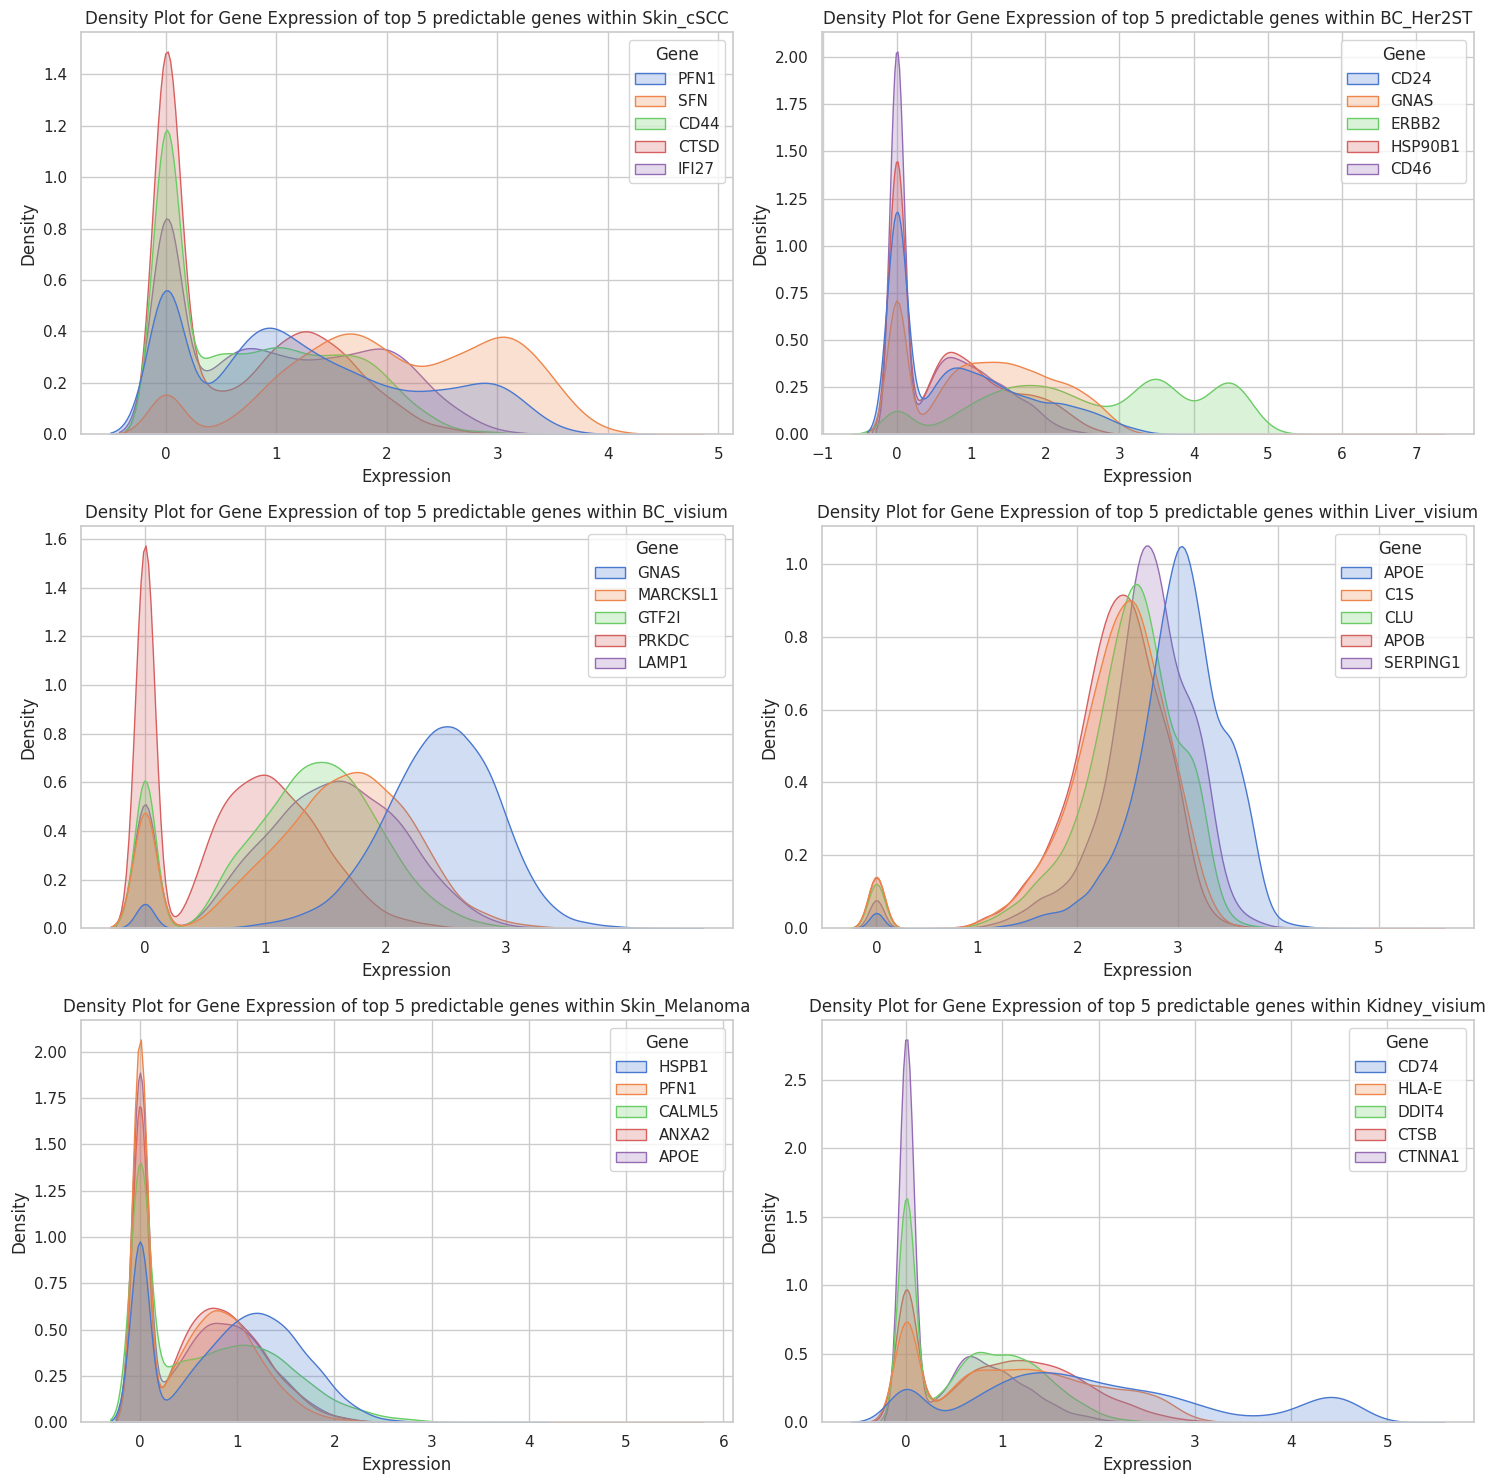

<Figure size 640x480 with 0 Axes>

In [30]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dataset_names = ["Skin_cSCC", "BC_Her2ST", "BC_visium", "Liver_visium", "Skin_Melanoma", "Kidney_visium"]

# Create a 2 x 3 subplot grid
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Iterate over datasets
for i, dataset_name in enumerate(dataset_names):
    # Load the adata of top 5 genes for each dataset
    if os.path.exists(f"../Dataset/Predictable_adata/Top5_{dataset_name}_func.h5ad"):
        predictable_adata = sc.read_h5ad(f"../Dataset/Predictable_adata/Top5_{dataset_name}_func.h5ad")
    else:
        predictable_adata = save_top5_genes_adata(dataset_name)

    # Add a column for the number of cells    
    predictable_adata.var["n_cells"] = np.sum(predictable_adata.to_df() > 0, axis=0)

    df = predictable_adata.to_df()
    melted_df = pd.melt(df, var_name='Gene', value_name='Expression')

    # Plot the density for each gene with hue
    sns.set(style="whitegrid", palette="muted")
    sns.kdeplot(data=melted_df, x='Expression', hue='Gene', common_norm=False, fill=True, ax=axes[i])

    # Add title and labels
    axes[i].set_title(f'Density Plot for Gene Expression of top 5 predictable genes within {dataset_name}')
    axes[i].set_xlabel('Expression')
    axes[i].set_ylabel('Density')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
plt.savefig(f"Top5_genes_density.pdf")
